# Regularization
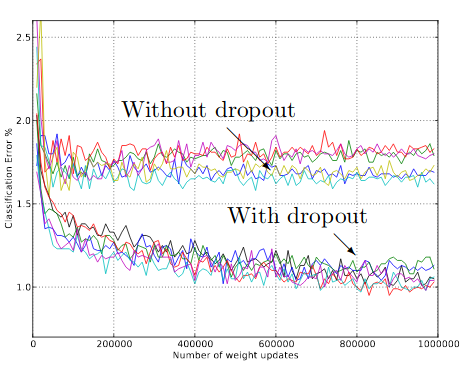

# Setup

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from IPython.display import Image

In [2]:
tf.__version__

'1.14.0'

# Data

In [3]:
cifar10 = keras.datasets.cifar10.load_data()

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10

In [5]:
print(f'Training Images {X_train.shape}, Labels {y_train.shape}')
print(f'Testing  Images {X_test.shape}, Labels {y_test.shape}')

Training Images (50000, 32, 32, 3), Labels (50000, 1)
Testing  Images (10000, 32, 32, 3), Labels (10000, 1)


In [6]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

X_train /= 255
X_test  /= 255

In [7]:
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

In [8]:
class_names = [
    'car',
    'plane',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

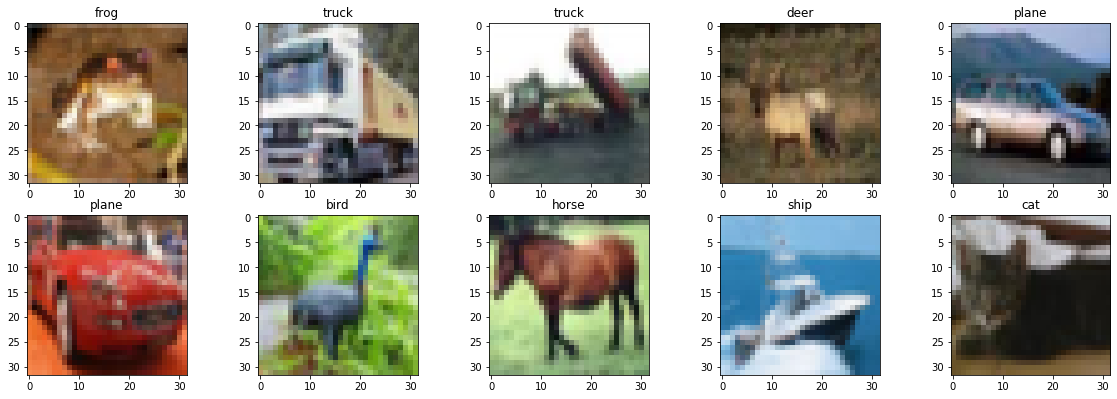

In [9]:
plt.figure(figsize=(20,10))
cols = 5
for i, image in enumerate(X_train[0:10, :]):
    plt.subplot(10 / cols + 1, cols, i + 1)
    plt.imshow(image.squeeze())
    plt.title(class_names[y_train[i].argmax()]);

# Helpers

In [36]:
def plot_performance(history, color_train='blue', color_val='red'):
    fig, ax = plt.subplots(figsize=(12,10))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Accuracy')
    plt.ylabel('Accuracy')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [125]:
def compare_history(histories, metric='val_acc', ylabel='Accuracy', title='Validation Accuracy'):
    colors = (c for c in ['blue', 'orange', 'green', 'black', 'red', 'purple'])
    fig, ax = plt.subplots(figsize=(12,10))
    
    ax = plt.subplot(2, 1, 1)
    for key, history in histories.items():
        val_acc = history.history[metric]
        epochs = range(1, len(val_acc) + 1)
        plt.plot(epochs, val_acc, 'b', label=key, color=next(colors))   
        plt.title(title)
        plt.ylabel(ylabel)
    ax.legend()
    
    plt.show();

In [12]:
def plot_confusion(test, pred):
    cm = confusion_matrix(test, pred)
    df = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize=(10, 10))
    sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

# Comparison

In [42]:
results_df = pd.DataFrame(columns=['Loss', 'Accuracy'])

In [81]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    return model

In [ ]:
batch_size=64
epochs=100

# Overfitting
* Regime identified by
    * Training loss decreasing 
    * Validation loss increasing
* Generalization accuracy diminishing

In [161]:
Image(url='https://i1.wp.com/mlexplained.com/wp-content/uploads/2018/04/three_curve.png?fit=418%2C341&ssl=1')

In [163]:
Image(url='https://static.packt-cdn.com/products/9781838556334/graphics/C12624_07_02.jpg')

## Model

In [140]:
model = create_model()
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [141]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_35 (Dense)             (None, 10)                1290      
Total params: 1,060,138
Trainable params: 1,060,138
Non-trainable params: 0
___________________________________________

## Train

In [24]:
history_overfit = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.6223 - acc: 0.4236 - val_loss: 1.5135 - val_acc: 0.4560
Epoch 2/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.4124 - acc: 0.4960 - val_loss: 1.3362 - val_acc: 0.5190
Epoch 3/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.2847 - acc: 0.5429 - val_loss: 1.2497 - val_acc: 0.5537
Epoch 4/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.1975 - acc: 0.5762 - val_loss: 1.1974 - val_acc: 0.5744
Epoch 5/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.1248 - acc: 0.6010 - val_loss: 1.1313 - val_acc: 0.5997
Epoch 6/100
50000/50000 [==============================] - 55s 1ms/sample - loss: 1.0500 - acc: 0.6336 - val_loss: 1.1016 - val_acc: 0.6105
Epoch 7/100
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.9909 - acc: 0.6540 - val_l

Epoch 59/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.0027 - acc: 0.9999 - val_loss: 2.4250 - val_acc: 0.6630
Epoch 60/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.0025 - acc: 1.0000 - val_loss: 2.4274 - val_acc: 0.6646
Epoch 61/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.0023 - acc: 1.0000 - val_loss: 2.4404 - val_acc: 0.6655
Epoch 62/100
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.0022 - acc: 1.0000 - val_loss: 2.4614 - val_acc: 0.6615
Epoch 63/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.0022 - acc: 1.0000 - val_loss: 2.4646 - val_acc: 0.6648
Epoch 64/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.0021 - acc: 1.0000 - val_loss: 2.4767 - val_acc: 0.6652
Epoch 65/100
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.0020 - acc: 1.0000 - val_loss: 2.4875 - val_acc: 0.6640
Epoch 66/100


## Test 

In [43]:
pred = model.predict_classes(X_test)
results = model.evaluate(X_test, y_test)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Overfit'] = [results[0], results[1]]

10000/10000 [==============================] - 2s 246us/sample - loss: 2.7512 - acc: 0.6632
Test Loss 2.75 Accuracy 66.32%


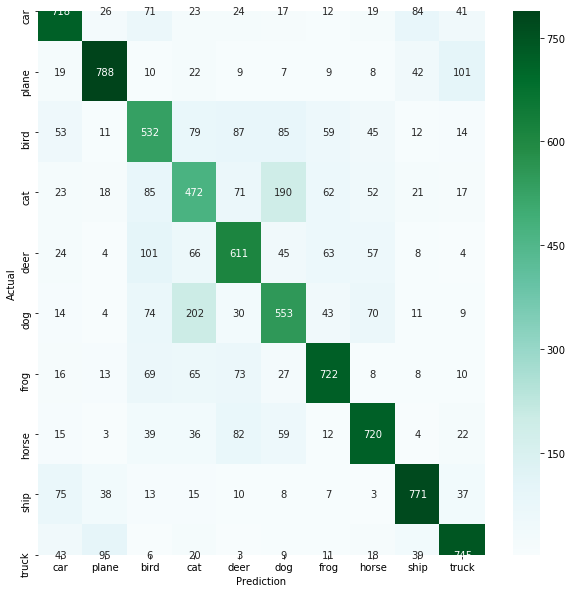

In [51]:
plot_confusion(pred, y_test.argmax(-1))

## Plots

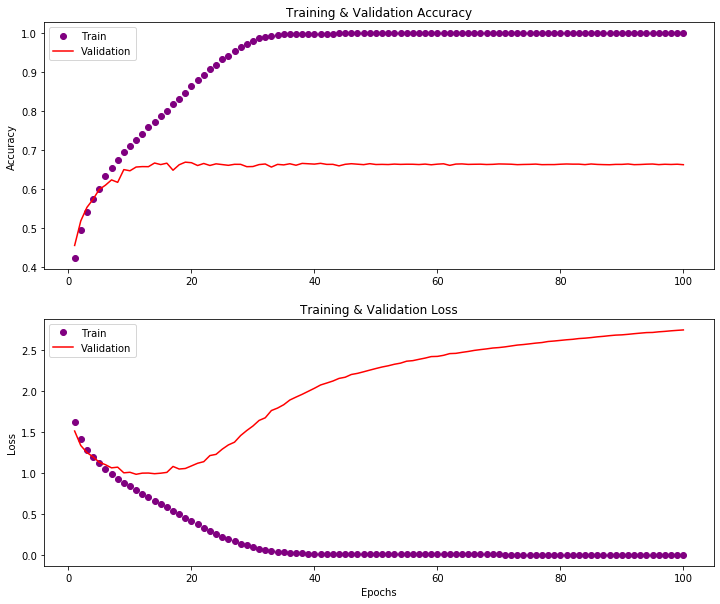

In [49]:
plot_performance(history_overfit, color_train='purple')

# Early Stopping
* Stop training after progress slows
* Alternative approach is to checkpoint, allowing you to run longer, but pick a stopping point
* http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf

## Model

In [58]:
model = create_model()
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history_early_stop = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_data=(X_test, y_test),
                            shuffle=True,
                            callbacks=[early_stop])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 57s 1ms/sample - loss: 1.7576 - acc: 0.3755 - val_loss: 1.5267 - val_acc: 0.4561
Epoch 2/100
50000/50000 [==============================] - 55s 1ms/sample - loss: 1.4051 - acc: 0.4990 - val_loss: 1.3525 - val_acc: 0.5117
Epoch 3/100
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.2644 - acc: 0.5539 - val_loss: 1.2130 - val_acc: 0.5756
Epoch 4/100
50000/50000 [==============================] - 56s 1ms/sample - loss: 1.1566 - acc: 0.5967 - val_loss: 1.2311 - val_acc: 0.5638
Epoch 5/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 1.0676 - acc: 0.6258 - val_loss: 1.1260 - val_acc: 0.6013
Epoch 6/100
50000/50000 [==============================] - 52s 1ms/sample - loss: 1.0015 - acc: 0.6499 - val_loss: 1.0833 - val_acc: 0.6230
Epoch 7/100
50000/50000 [==============================] - 52s 1ms/sample - loss: 0.9369 - acc: 0.6734 - val_l

## Test

In [60]:
pred = model.predict_classes(X_test)
results = model.evaluate(X_test, y_test)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Early Stop'] = [results[0], results[1]]

10000/10000 [==============================] - 2s 222us/sample - loss: 0.9816 - acc: 0.6742
Test Loss 0.98 Accuracy 67.42%


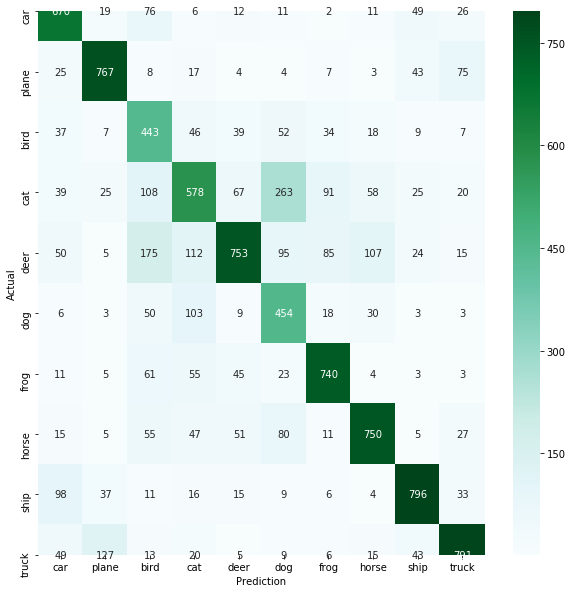

In [61]:
plot_confusion(pred, y_test.argmax(-1))

## Plots

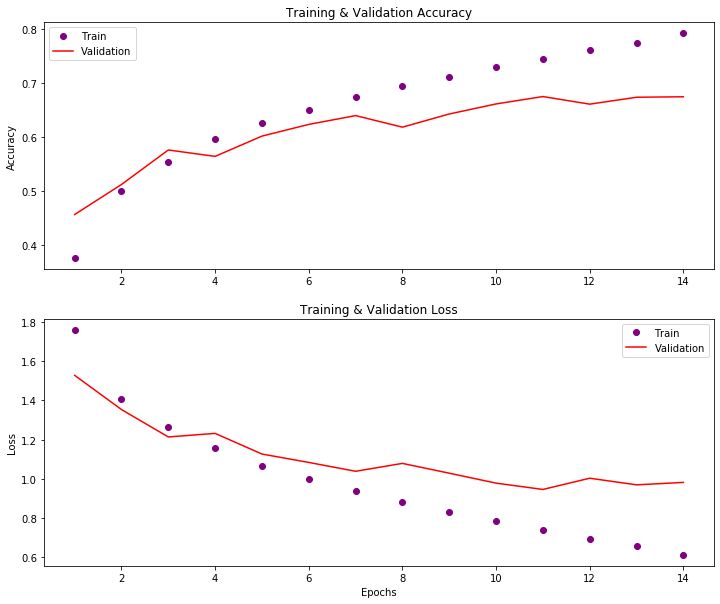

In [63]:
plot_performance(history_early_stop, color_train='purple')

# Data Augmentation
* We perturb the training data in various ways
    * Rotation
    * Noise
    * Cropping
    * Shifting Up - Down / Left - Right
* Time Series Data Augmentation for Deep Learning: A Survey (http://arxiv.org/abs/2002.12478)

In [72]:
def plot_batch(datagen, X_train, y_train):
    datagen.fit(X_train)
    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
        for counter in range(0, 9):
            plt.subplot(330 + 1 + counter)
            plt.imshow(X_batch[counter].reshape(32, 32, 3))
        plt.show()
        break

## Horizontal / Vertical Shift

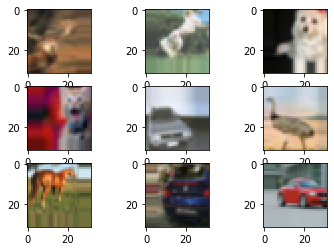

In [73]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
plot_batch(datagen, X_train, y_train)

## Flip

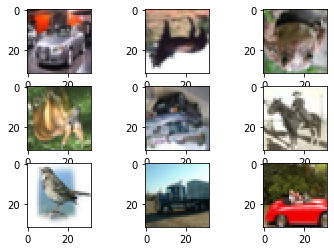

In [74]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
plot_batch(datagen, X_train, y_train)

## Rotate

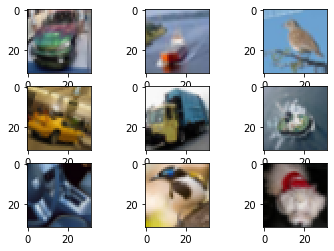

In [79]:
datagen = ImageDataGenerator(rotation_range=20)
plot_batch(datagen, X_train, y_train)

## Model

In [82]:
model = create_model()
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [83]:
datagen = ImageDataGenerator(width_shift_range=0.2, 
                             height_shift_range=0.2,
                             rotation_range=20,
                             horizontal_flip=True, 
                             vertical_flip=True)

## Train

In [85]:
datagen.fit(X_train)

In [86]:
history_augmentation = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                                 steps_per_epoch = len(X_train) / batch_size, 
                                 epochs=epochs,
                                 validation_data=(X_test, y_test))

Epoch 1/100
782/781 [==============================] - 62s 79ms/step - loss: 2.0010 - acc: 0.2660 - val_loss: 1.8065 - val_acc: 0.3518
Epoch 2/100
782/781 [==============================] - 59s 76ms/step - loss: 1.8100 - acc: 0.3389 - val_loss: 1.6706 - val_acc: 0.3919
Epoch 3/100
782/781 [==============================] - 54s 69ms/step - loss: 1.7042 - acc: 0.3752 - val_loss: 1.5677 - val_acc: 0.4258 4s - loss: - ETA: 3s - loss: 1.706 - ETA: 2s - loss: 1.7052 - acc: 0 - ETA: 1s 
Epoch 4/100
782/781 [==============================] - 58s 74ms/step - loss: 1.6339 - acc: 0.4008 - val_loss: 1.5259 - val_acc: 0.4495
Epoch 5/100
782/781 [==============================] - 56s 72ms/step - loss: 1.5998 - acc: 0.4159 - val_loss: 1.4537 - val_acc: 0.4752
Epoch 6/100
782/781 [==============================] - 57s 73ms/step - loss: 1.5624 - acc: 0.4323 - val_loss: 1.4403 - val_acc: 0.4851
Epoch 7/100
782/781 [==============================] - 58s 74ms/step - loss: 1.5456 - acc: 0.4369 - val_loss: 

782/781 [==============================] - 57s 73ms/step - loss: 1.0937 - acc: 0.6106 - val_loss: 1.1444 - val_acc: 0.6074
Epoch 59/100
782/781 [==============================] - 58s 74ms/step - loss: 1.0919 - acc: 0.6112 - val_loss: 1.1366 - val_acc: 0.6175
Epoch 60/100
782/781 [==============================] - 57s 73ms/step - loss: 1.0897 - acc: 0.6115 - val_loss: 1.0378 - val_acc: 0.6375
Epoch 61/100
782/781 [==============================] - 56s 71ms/step - loss: 1.0828 - acc: 0.6150 - val_loss: 1.1089 - val_acc: 0.6225
Epoch 62/100
782/781 [==============================] - 56s 72ms/step - loss: 1.0790 - acc: 0.6135 - val_loss: 1.0874 - val_acc: 0.6247
Epoch 63/100
782/781 [==============================] - 58s 74ms/step - loss: 1.0706 - acc: 0.6205 - val_loss: 1.1088 - val_acc: 0.6186
Epoch 64/100
782/781 [==============================] - 53s 68ms/step - loss: 1.0704 - acc: 0.6188 - val_loss: 1.1117 - val_acc: 0.6176ss: - ETA: 4s - loss: 1.0678 - ac - ETA: 3s - loss: - ETA: 2s 

## Test

In [87]:
pred = model.predict_classes(X_test)
results = model.evaluate(X_test, y_test)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Augmentation'] = [results[0], results[1]]

10000/10000 [==============================] - 2s 233us/sample - loss: 1.0735 - acc: 0.6366
Test Loss 1.07 Accuracy 63.66%


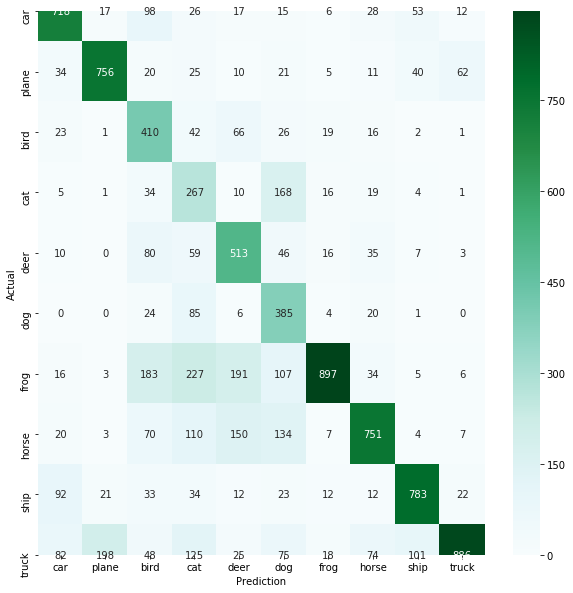

In [88]:
plot_confusion(pred, y_test.argmax(-1))

## Plots

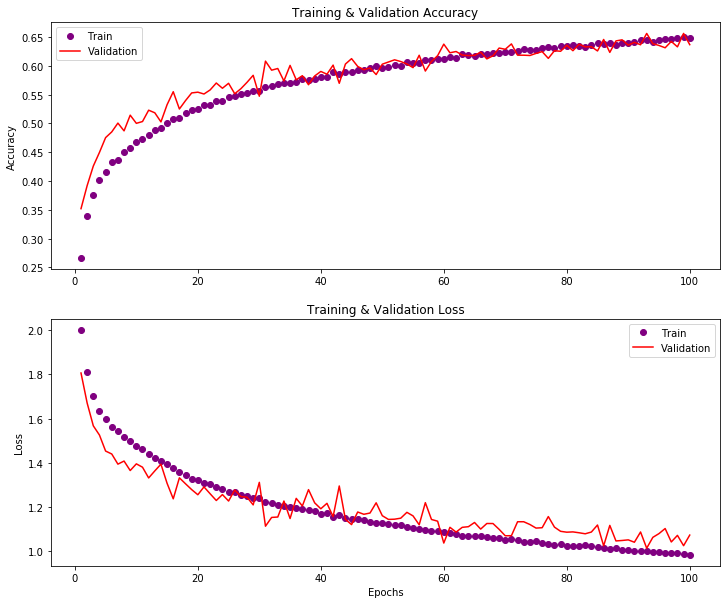

In [89]:
plot_performance(history_augmentation, color_train='purple')

# L1 - L2 Regularization - Weight Decay
* L1
    * Sum of absolute value of weights
    * Promotes sparsity
* L2
    * Sum of squared weights
    * Promotes small weights
* Approaches
    * Loss
    * Weight Decay
    * Layer
* Layer Regularizers
    * L1, L2, L1_L2 Layer Regularizer
    * Kernel = Make weights smalle
    * Bias = Make bias units small
    * Activity = Make mX + b small
* Papers
    * A Simple Weight Decay Can Improve Generalization (http://papers.nips.cc/paper/563-a-simple-weight-decay-can-improve-generalization.pdf)
    * Three Mechanisms of Weight Decay Regularization (http://openreview.net/pdf?B1lz-3Rct7)

## Model

In [132]:
decay = 0.1
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(decay), bias_regularizer=l2(decay)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(decay), bias_regularizer=l2(decay)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', 
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(decay), bias_regularizer=l2(decay)))
model.add(Dense(10, activation='softmax'))

In [133]:
model = create_model()
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train

In [134]:
history_weightdecay = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 60s 1ms/sample - loss: 1.7571 - acc: 0.3720 - val_loss: 1.5202 - val_acc: 0.4599
Epoch 2/100
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.4362 - acc: 0.4895 - val_loss: 1.3340 - val_acc: 0.5324
Epoch 3/100
50000/50000 [==============================] - 55s 1ms/sample - loss: 1.2885 - acc: 0.5415 - val_loss: 1.2628 - val_acc: 0.5438
Epoch 4/100
50000/50000 [==============================] - 56s 1ms/sample - loss: 1.1811 - acc: 0.5826 - val_loss: 1.1606 - val_acc: 0.5909
Epoch 5/100
50000/50000 [==============================] - 55s 1ms/sample - loss: 1.0925 - acc: 0.6155 - val_loss: 1.1608 - val_acc: 0.5871
Epoch 6/100
50000/50000 [==============================] - 57s 1ms/sample - loss: 1.0248 - acc: 0.6418 - val_loss: 1.0911 - val_acc: 0.6151
Epoch 7/100
50000/50000 [==============================] - 57s 1ms/sample - loss: 0.9616 - acc: 0.6639 - val_l

Epoch 59/100
50000/50000 [==============================] - 57s 1ms/sample - loss: 0.0027 - acc: 1.0000 - val_loss: 2.3332 - val_acc: 0.6677
Epoch 60/100
50000/50000 [==============================] - 56s 1ms/sample - loss: 0.0025 - acc: 1.0000 - val_loss: 2.3438 - val_acc: 0.6676
Epoch 61/100
50000/50000 [==============================] - 58s 1ms/sample - loss: 0.0024 - acc: 1.0000 - val_loss: 2.3570 - val_acc: 0.6674
Epoch 62/100
50000/50000 [==============================] - 58s 1ms/sample - loss: 0.0024 - acc: 1.0000 - val_loss: 2.3646 - val_acc: 0.6678
Epoch 63/100
50000/50000 [==============================] - 57s 1ms/sample - loss: 0.0025 - acc: 0.9999 - val_loss: 2.3785 - val_acc: 0.6666
Epoch 64/100
50000/50000 [==============================] - 57s 1ms/sample - loss: 0.0022 - acc: 1.0000 - val_loss: 2.3878 - val_acc: 0.6685
Epoch 65/100
50000/50000 [==============================] - 56s 1ms/sample - loss: 0.0021 - acc: 1.0000 - val_loss: 2.4002 - val_acc: 0.6659
Epoch 66/100


## Test

In [135]:
pred = model.predict_classes(X_test)
results = model.evaluate(X_test, y_test)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Weight Decay'] = [results[0], results[1]]

10000/10000 [==============================] - 3s 256us/sample - loss: 2.6506 - acc: 0.6658
Test Loss 2.65 Accuracy 66.58%


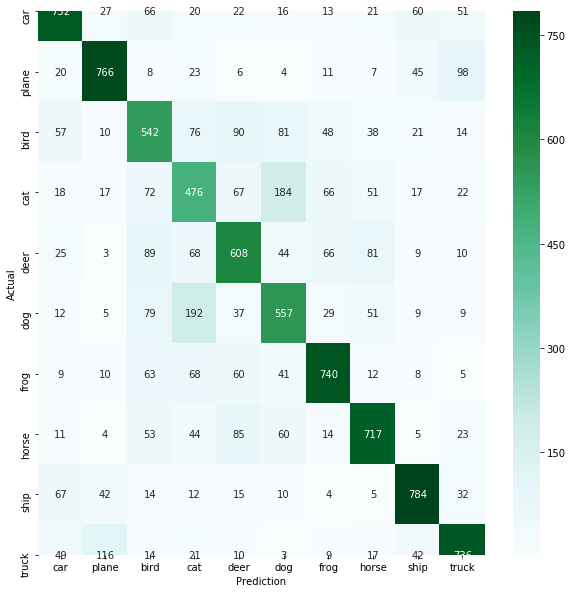

In [136]:
plot_confusion(pred, y_test.argmax(-1))

## Plots

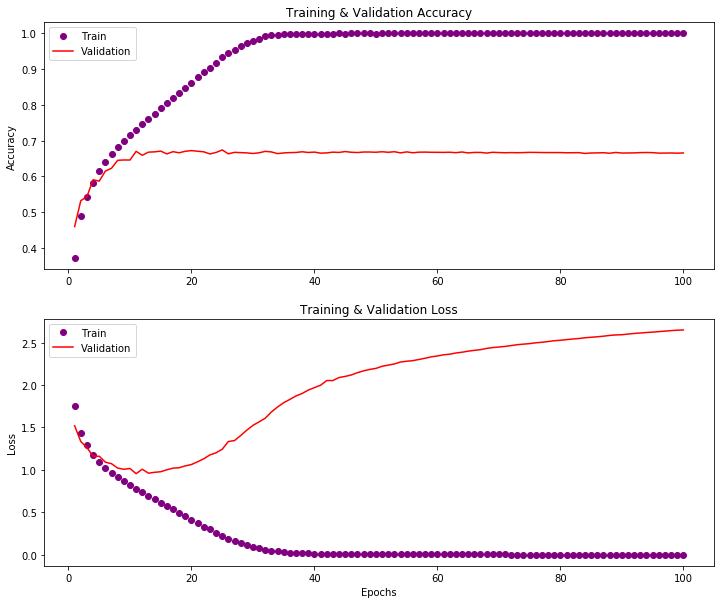

In [137]:
plot_performance(history_weightdecay, color_train='purple')

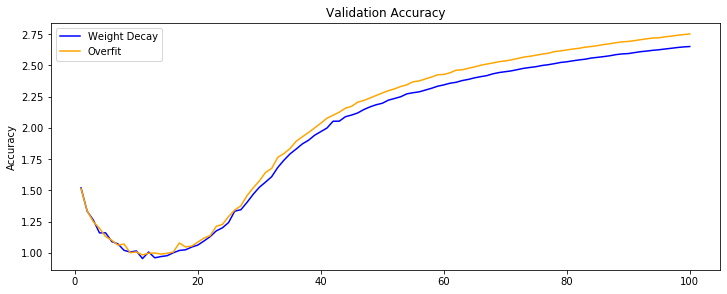

In [138]:
compare_history({'Weight Decay':history_weightdecay, 'Overfit':history_overfit}, metric='val_loss')

# Dropout
* We apply a filter "removing" nodes from the network
    * Applies only during training
    * Effectively removes nodes from the network
    * We compensate by increasing magnitude of output
    * Redraw filter each batch
* This forces the network to work harder - more robust
* Conceptually, dropout is a form of ensembling
    * We train subnetworks based on the dropped out nodes
    * Must adapt and learn multiple representations
        * Redundant features
        * Alternative features 
* Takes additional epochs to converge
* Dropout: A Simple Way to Prevent Neural Networks from Overfitting (http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

In [155]:
Image(url='https://miro.medium.com/max/1400/1*iWQzxhVlvadk6VAJjsgXgg.png')

## Model

In [98]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [99]:
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

## Train

In [100]:
history_dropout = model.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 60s 1ms/sample - loss: 1.9615 - acc: 0.2840 - val_loss: 1.6155 - val_acc: 0.4308
Epoch 2/100
50000/50000 [==============================] - 56s 1ms/sample - loss: 1.6496 - acc: 0.4039 - val_loss: 1.4384 - val_acc: 0.4918
Epoch 3/100
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.5122 - acc: 0.4554 - val_loss: 1.3600 - val_acc: 0.5146
Epoch 4/100
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.4293 - acc: 0.4843 - val_loss: 1.2762 - val_acc: 0.5492
Epoch 5/100
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.3619 - acc: 0.5101 - val_loss: 1.2309 - val_acc: 0.5574
Epoch 6/100
50000/50000 [==============================] - 60s 1ms/sample - loss: 1.3050 - acc: 0.5315 - val_loss: 1.1604 - val_acc: 0.5914
Epoch 7/100
50000/50000 [==============================] - 59s 1ms/sample - loss: 1.2531 - acc: 0.5528 - val_l

50000/50000 [==============================] - 57s 1ms/sample - loss: 0.5025 - acc: 0.8166 - val_loss: 0.8587 - val_acc: 0.7161
Epoch 59/100
50000/50000 [==============================] - 56s 1ms/sample - loss: 0.4981 - acc: 0.8197 - val_loss: 0.8699 - val_acc: 0.7162
Epoch 60/100
50000/50000 [==============================] - 58s 1ms/sample - loss: 0.4920 - acc: 0.8220 - val_loss: 0.8551 - val_acc: 0.7160
Epoch 61/100
50000/50000 [==============================] - 57s 1ms/sample - loss: 0.4824 - acc: 0.8255 - val_loss: 0.8561 - val_acc: 0.7190
Epoch 62/100
50000/50000 [==============================] - 54s 1ms/sample - loss: 0.4721 - acc: 0.8288 - val_loss: 0.8617 - val_acc: 0.7183
Epoch 63/100
50000/50000 [==============================] - 58s 1ms/sample - loss: 0.4727 - acc: 0.8266 - val_loss: 0.8712 - val_acc: 0.7113
Epoch 64/100
50000/50000 [==============================] - 57s 1ms/sample - loss: 0.4625 - acc: 0.8319 - val_loss: 0.8585 - val_acc: 0.7221
Epoch 65/100
50000/50000 [

## Test

In [101]:
pred = model.predict_classes(X_test)
results = model.evaluate(X_test, y_test)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Dropout'] = [results[0], results[1]]

10000/10000 [==============================] - 2s 247us/sample - loss: 1.0073 - acc: 0.7159
Test Loss 1.01 Accuracy 71.59%


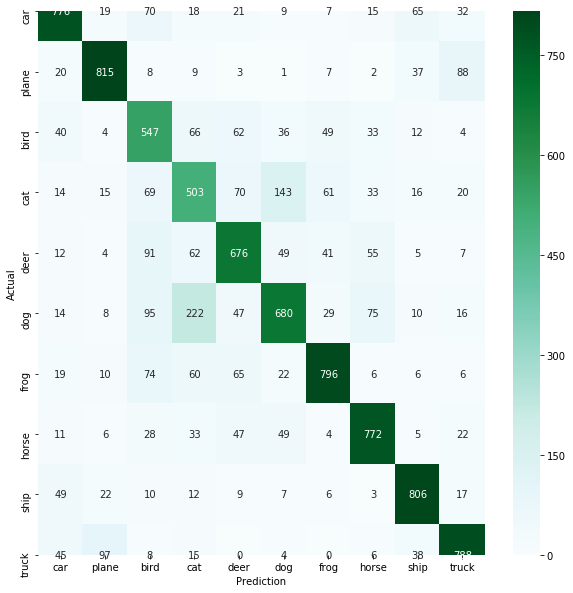

In [102]:
plot_confusion(pred, y_test.argmax(-1))

## Plot

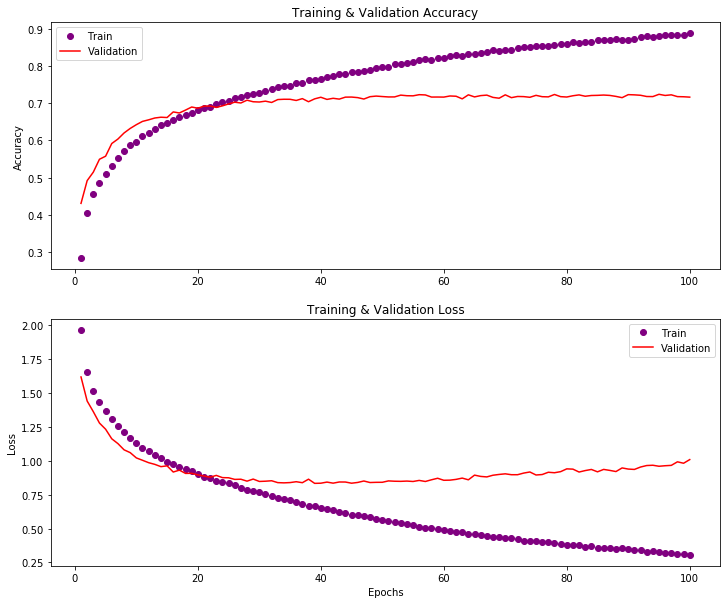

In [103]:
plot_performance(history_dropout, color_train='purple')

# Results

In [104]:
results_df

,Loss,Accuracy
Overfit,2.751234,0.6632
Early Stop,0.981609,0.6742
Augmentation,1.073523,0.6366
Weight Decay,2.563342,0.6654
Dropout,1.007338,0.7159


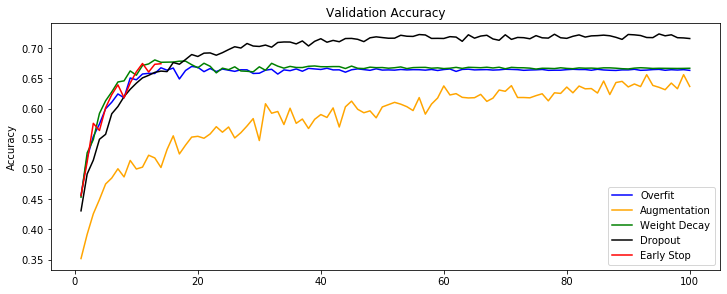

In [130]:
compare_history({'Overfit': history_overfit,
                 'Augmentation': history_augmentation,
                 'Weight Decay': history_weightdecay,
                 'Dropout': history_dropout,
                 'Early Stop': history_early_stop}, 
                metric='val_acc', 
                ylabel='Accuracy', 
                title='Validation Accuracy')

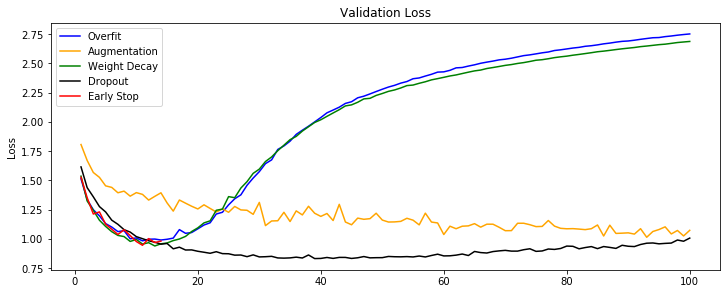

In [131]:
compare_history({'Overfit': history_overfit,
                 'Augmentation': history_augmentation,
                 'Weight Decay': history_weightdecay,
                 'Dropout': history_dropout,
                 'Early Stop': history_early_stop}, 
                metric='val_loss', 
                ylabel='Loss', 
                title='Validation Loss')

# Recap
* Overall Approach
    * Get network to overfit 
    * Add Regularization 
    * Expand capacity / Increase Learning Rate
    * Measure
    * Repeat
* Regularizing
    * Combine multiple regularization techniques
    * Dropout is usually effective
    * Augmentation is helpful (can help with TimeSeries)
    * Weight Decay
* Time concerns - consider early stop
* Incremental training - Checkpoint model